In [22]:
import numpy as np
import colour
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import os

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2  # type:ignore

In [23]:
def gaussian_piecewise(x, params):
    # Output represents density
    # Ported basically verbatim from the dye sim code
    if x < params['mean']:
        out = np.exp(-1 * (1.0 / params['left_std'])**2 * (x - params['mean'])**2 / 2.0)
    else:
        out = np.exp(-1 * (1.0 / params['right_std'])**2 * (x - params['mean'])**2 / 2.0)
    out = out * (params['max_value'] - params['min_value']) + params['min_value']
    return out

def gaussian_piecewise_arr(x, params):
    out = []
    for entry in x:
        out.append(gaussian_piecewise(entry, params))
    return np.array(out)

def density_to_transmitance(density):
    return np.power(10.0, -1.0 * density)

In [24]:
def params_converter(params):
    # Params is list of 15 values.
    # Convert to three dictionaries for cyan, magenta, and yellow
    cyan_params = {
        'mean': params[0],
        'left_std': params[1],
        'right_std': params[2],
        'min_value': params[3],
        'max_value': params[4],
    }
    magenta_params = {
        'mean': params[5],
        'left_std': params[6],
        'right_std': params[7],
        'min_value': params[8],
        'max_value': params[9],
    }
    yellow_params = {
        'mean': params[10],
        'left_std': params[11],
        'right_std': params[12],
        'min_value': params[13],
        'max_value': params[14],
    }

    curve_params = {
        'red': {
            'contrast': params[15],
            'offset': params[16],
        },
        'green': {
            'contrast': params[17],
            'offset': params[18],
        },
        'blue': {
            'contrast': params[19],
            'offset': params[20],
        }

    }

    # cyan2_params = {
    #     'mean': params[21],
    #     'left_std': params[22],
    #     'right_std': params[23],
    #     'min_value': params[24],
    #     'max_value': params[25],
    # }
    # return cyan_params, cyan2_params, magenta_params, yellow_params, curve_params
    return cyan_params, magenta_params, yellow_params, curve_params

init_params = [
    651.0, 60.0, 60.0, 0.0, 1.08,
    522.0, 50.0, 50.0, 0.0, 0.75,
    420.0, 60.0, 60.0, 0.0, 0.82,
    4.0, 0.25, 4.0, 0.25, 4.0, 0.25,
    # 400.0, 60.0, 40.0, 0.0, 0.5,
]

bounds = [
    (300.0, 800.0),  # Cyan mean
    (0.0, 150.0),   # Cyan left std
    (0.0, 150.0),   # Cyan right std
    (0.0, 0.2),     # Cyan min value
    (0.2, 2.5),     # Cyan max value
    (300.0, 800.0),  # Magenta mean
    (0.0, 150.0),   # Magenta left std
    (0.0, 150.0),   # Magenta right std
    (0.0, 0.2),     # Magenta min value
    (0.2, 2.5),     # Magenta max value
    (300.0, 800.0),  # Yellow mean
    (0.0, 150.0),   # Yellow left std
    (0.0, 150.0),   # Yellow right std
    (0.0, 0.2),     # Yellow min value
    (0.2, 2.5),     # Yellow max value
    (1.0, 6.0),   # Red contrast
    (-4.0, 4.0),   # Red offset
    (1.0, 6.0),   # Green contrast
    (-4.0, 4.0),   # Green offset
    (1.0, 6.0),   # Blue contrast
    (-4.0, 4.0),   # Blue offset

    # (300.0, 800.0),  # Cyan2 mean
    # (0.0, 150.0),   # Cyan2 left std
    # (0.0, 150.0),   # Cyan2 right std
    # (0.0, 0.0),     # Cyan2 min value
    # (0.1, 1.5),     # Cyan2 max value
]

cyan_dye_params, magenta_dye_params, yellow_dye_params, curve_params = params_converter(init_params)
# cyan_dye_params, cyan2_dye_params, magenta_dye_params, yellow_dye_params, curve_params = params_converter(init_params)

def sigmoid(x):
    # Sigmoid function for dye concentration
    return 1.0 / (1.0 + np.exp(-x))

def cineon_to_dye_concentration(x, chan_curve_params):
    density = (x * 1023.0 - 95.0) * 0.002
    exposure = 10**(-1.0 * density)
    log_exposure = np.log10(exposure)

    coeff = chan_curve_params['contrast'] / (0.25 * (4.0 - 0.0))
    offset = chan_curve_params['offset']
    out = sigmoid(coeff * (log_exposure + offset)) * 4.0 + 0.0
    return out



In [25]:
xyz_cmfs = colour.colorimetry.MSDS_CMFS_STANDARD_OBSERVER["CIE 1931 2 Degree Standard Observer"]
wavelengths = xyz_cmfs.wavelengths
illuminant = colour.sd_CIE_standard_illuminant_A(xyz_cmfs)

# Get the chromatic adaptation matrix from illuminant to D65
illuminant_XYZ = colour.sd_to_XYZ(illuminant, xyz_cmfs)
d65_sd = colour.SDS_ILLUMINANTS["D65"]
d65_XYZ = colour.sd_to_XYZ(d65_sd, xyz_cmfs)

def XYZ_to_xy(XYZ):
    # Convert XYZ to xy chromaticity coordinates
    x, y, z = XYZ
    total = x + y + z
    if total == 0:
        return np.array([0.0, 0.0])
    return np.array([x / total, y / total])

# Get xy chromaticity coordinates for source (illuminant) and destination (D65)
source_white_xy = XYZ_to_xy(illuminant_XYZ)
dest_white_xy = XYZ_to_xy(d65_XYZ)

# CAT02 matrix
cat02_matrix = np.array([
    [0.7328, 0.4296, -0.1624],
    [-0.7036, 1.6975, 0.0061],
    [0.0030, 0.0136, 0.9834]
])
cat02_inv = np.linalg.inv(cat02_matrix)

# Convert xy to XYZ (Y=1)
def xy_to_XYZ(xy):
    x, y = xy
    return np.array([x / y, 1.0, (1 - x - y) / y])

source_white = xy_to_XYZ(source_white_xy)
dest_white = xy_to_XYZ(dest_white_xy)

source_lms = cat02_matrix @ source_white
dest_lms = cat02_matrix @ dest_white

diag = np.diag(dest_lms / source_lms)
adaptation_matrix = cat02_inv @ diag @ cat02_matrix

xyz_to_rec709_matrix = [
    [ 3.240970, -1.537383, -0.498611],
    [-0.969244,  1.875968,  0.041555],
    [ 0.055630, -0.203977,  1.056972],
]

In [ ]:
cyan_concentration = 1.0
magenta_concentration = 0.5
yellow_concentration = 0.25

def model(params, rgb_cineon):
    assert len(rgb_cineon.shape) == 2 and rgb_cineon.shape[1] == 3
    output = np.zeros_like(rgb_cineon)
    # cyan_dye_params, cyan2_dye_params, magenta_dye_params, yellow_dye_params, curve_params = params_converter(params)
    cyan_dye_params, magenta_dye_params, yellow_dye_params, curve_params = params_converter(params)

    cyan_sdd = gaussian_piecewise_arr(wavelengths, cyan_dye_params)
    # cyan2_sdd = gaussian_piecewise_arr(wavelengths, cyan2_dye_params)

    cyan_transmittance = density_to_transmitance(cyan_sdd)
    # cyan_transmittance = density_to_transmitance(cyan_sdd + cyan2_sdd)


    magenta_sdd = gaussian_piecewise_arr(wavelengths, magenta_dye_params)
    magenta_transmittance = density_to_transmitance(magenta_sdd)

    yellow_sdd = gaussian_piecewise_arr(wavelengths, yellow_dye_params)
    yellow_transmittance = density_to_transmitance(yellow_sdd)

    for i in range(rgb_cineon.shape[0]):
        rgb = rgb_cineon[i]
        cyan_concentration = cineon_to_dye_concentration(rgb[0], curve_params['red'])
        magenta_concentration = cineon_to_dye_concentration(rgb[1], curve_params['green'])
        yellow_concentration = cineon_to_dye_concentration(rgb[2], curve_params['blue'])

        curr_cyan_transmittance = np.power(cyan_transmittance, cyan_concentration)
        curr_magenta_transmittance = np.power(magenta_transmittance, magenta_concentration)
        curr_yellow_transmittance = np.power(yellow_transmittance, yellow_concentration)

        combo_transmittance = curr_cyan_transmittance * curr_magenta_transmittance * curr_yellow_transmittance

        combo_transmittance *= illuminant.values / 100.0
        xyz = colour.sd_to_XYZ(colour.SpectralDistribution(combo_transmittance, wavelengths), xyz_cmfs) / 100.0
        assert xyz.shape == (3,)

        rec709_linear = xyz_to_rec709_matrix @ adaptation_matrix @ xyz
        rec709_linear = np.clip(rec709_linear, 0.0, 1.0)
        output[i] = np.power(rec709_linear, 1.0 / 2.4)

    return output


def rgb2oklab(rgb):
    M1 = np.array([
        [0.4122214708, 0.5363325363, 0.0514459929],
        [0.2119034982, 0.6806995451, 0.1073969566],
        [0.0883024619, 0.2817188376, 0.6299787005]
    ])
    M2 = np.array([
        [0.2104542553, 0.7936177850, -0.0040720468],
        [1.9779984951, -2.4285922050, 0.4505937099],
        [0.0259040371, 0.7827717662, -0.8086757660]
    ])

    lin = np.power(rgb, 2.4) # Assume gamma 2.4 encoded image.
    lms = np.tensordot(lin, M1.T, axes=1)
    lms = np.cbrt(lms)
    oklab = np.tensordot(lms, M2.T, axes=1)
    return oklab


def loss_function(params, rgb_cineon_input, target_output):
    output = model(params, rgb_cineon_input)
    # loss = np.mean(np.abs(output - target_output))
    loss = np.mean((output - target_output)**2)
    # target_oklab = rgb2oklab(target_output)
    # output_oklab = rgb2oklab(output)
    # loss = np.mean(np.abs(output_oklab - target_oklab))
    return loss

In [27]:
# Unit test

# assert np.linalg.norm(model(init_params, np.array([[0.25, 0.25, 0.35]])) - np.array([[ 0.17850025,  0.20860188,  0.313503  ]])) < 1e-5, "problem!"

In [28]:


def open_image(image_fn: str) -> np.ndarray:
    print(f"Reading: {image_fn}")
    os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
    img: np.ndarray = cv2.imread(image_fn, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    print(f"Read image data type of {img.dtype}")
    if img.dtype == np.uint8 or img.dtype == np.uint16:
        img = img.astype(np.float32) / np.iinfo(img.dtype).max
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def flatten(image):
    # Flatten the image to a 2D array of RGB values
    if len(image.shape) == 3 and image.shape[2] == 3:
        return image.reshape(-1, 3)
    else:
        raise ValueError("Input image must be a 3-channel RGB image.")

original_rgb_cineon_input = open_image("low_sat_hald0000.exr")
image_shape = original_rgb_cineon_input.shape
rgb_cineon_input = flatten(original_rgb_cineon_input)

original_target_output = open_image("2383_lut0000.exr")
target_output = flatten(original_target_output)



target_output.shape, loss_function(init_params, rgb_cineon_input, target_output)

Reading: low_sat_hald0000.exr
Read image data type of float32
Reading: 2383_lut0000.exr
Read image data type of float32


((125, 3), 0.015871475)

In [29]:
assert np.linalg.norm(original_target_output - target_output.reshape(image_shape)) < 1e-6
assert np.linalg.norm(original_rgb_cineon_input - rgb_cineon_input.reshape(image_shape)) < 1e-6

In [30]:
result = minimize(loss_function, init_params, args=(rgb_cineon_input, target_output), bounds=bounds, method='Powell', callback=lambda intermediate_result: print(f"Current loss: {intermediate_result.fun}"), options={"maxiter": 100})
result

Current loss: 0.004475416149944067
Current loss: 0.0018036909168586135
Current loss: 0.0011790854623541236
Current loss: 0.0009545640787109733
Current loss: 0.0007109252619557083
Current loss: 0.0007020739139989018
Current loss: 0.0006974502466619015
Current loss: 0.0006909202202223241
Current loss: 0.0006883409805595875
Current loss: 0.0006820583948865533
Current loss: 0.0006807519821450114
Current loss: 0.0006786428857594728
Current loss: 0.0006775786750949919
Current loss: 0.0006503889453597367
Current loss: 0.0006456572446040809
Current loss: 0.0006423944723792374
Current loss: 0.0006336159422062337
Current loss: 0.0006286530988290906
Current loss: 0.0006113090785220265
Current loss: 0.0006085538188926876
Current loss: 0.0006084529450163245
Current loss: 0.0006081998581066728
Current loss: 0.0006073722615838051
Current loss: 0.0006071257521398365
Current loss: 0.0006300171371549368


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.000630017
       x: [ 6.686e+02  4.929e+01 ...,  3.399e+00  1.831e-01]
     nit: 25
   direc: [[ 1.755e+00  1.144e+00 ..., -6.310e-03 -7.832e-03]
           [ 0.000e+00  1.000e+00 ...,  0.000e+00  0.000e+00]
           ..., 
           [ 0.000e+00  0.000e+00 ...,  1.000e+00  0.000e+00]
           [-4.049e-02 -6.780e-04 ..., -2.845e-03 -1.758e-04]]
    nfev: 9977

In [31]:
params_converter(result.x)

({'mean': 668.5546069568976,
  'left_std': 49.290801775496185,
  'right_std': 149.58429381590756,
  'min_value': 0.086542168722191212,
  'max_value': 2.0866536426940305},
 {'mean': 545.11733066130296,
  'left_std': 47.200018910710767,
  'right_std': 43.01781433780971,
  'min_value': 5.6006716414516617e-05,
  'max_value': 0.85429538737306587},
 {'mean': 445.64759247374292,
  'left_std': 71.089082151395189,
  'right_std': 34.955617924551703,
  'min_value': 0.014804169326172532,
  'max_value': 1.408871692054301},
 {'red': {'contrast': 4.014631496960865, 'offset': 0.22386628440307013},
  'green': {'contrast': 3.5210760834952226, 'offset': 0.38359439247639959},
  'blue': {'contrast': 3.3993285850768791, 'offset': 0.18313791287601133}})

In [32]:
loss_function(result.x, rgb_cineon_input, target_output)

0.00063001714

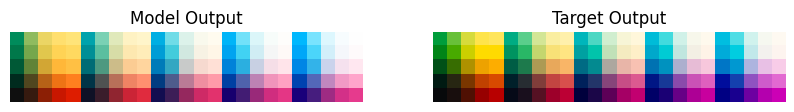

In [33]:
# Apply the model using the optimized parameters
predicted_output = model(init_params, rgb_cineon_input).reshape(image_shape)
target_img = target_output.reshape(image_shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Model Output")
plt.imshow(np.clip(predicted_output, 0, 1))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Target Output")
plt.imshow(np.clip(target_img, 0, 1))
plt.axis('off')

plt.show()